In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# Setup

In [2]:
import torch 

import albumentations as A

from torch.utils.data import DataLoader
from coralscapesScripts.datasets.dataset import Coralscapes
from coralscapesScripts.datasets.preprocess import get_preprocessor
from coralscapesScripts.datasets.utils import calculate_weights

from coralscapesScripts.segmentation.model import Benchmark_Run
from coralscapesScripts.segmentation.benchmarking import launch_benchmark

from coralscapesScripts.visualization import show_samples

from coralscapesScripts.logger import Logger, save_benchmark_run
from coralscapesScripts.io import setup_config, get_parser, update_config_with_args
import copy

/home/viktor/micromamba/envs/coralscapes/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [4]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

CUDA Device 0: NVIDIA GeForce RTX 2080 Ti
CUDA Device 1: NVIDIA GeForce GTX 980 Ti


device(type='cuda')

## Config

In [5]:
cfg = setup_config(config_path='../configs/deeplabv3+resnet50.yaml', config_base_path='../configs/base.yaml')

## Args

In [6]:
args_input = "--run-name=notebook_test_run --batch-size=2 --batch-size-eval=2 --epochs=100"
args_input = args_input.split(" ")

parser = get_parser()
args = parser.parse_args(args_input)

cfg = update_config_with_args(cfg, args)
cfg_logger = copy.deepcopy(cfg)

# Data

In [7]:
transforms = {}
for split in cfg.augmentation:
    transforms[split] = A.Compose(
        [
            getattr(A, transform_name)(**transform_params) for transform_name, transform_params
                                                                 in cfg.augmentation[split].items()
        ]
    )

In [8]:
train_dataset = Coralscapes(root = cfg.data.root, split = 'train', transform = transforms["train"])
transform_target = cfg.training.eval.transform_target if cfg.training.eval is not None and cfg.training.eval.transform_target is not None else True
val_dataset = Coralscapes(root = cfg.data.root, split = 'val', transform = transforms["val"], transform_target=transform_target) 
test_dataset = Coralscapes(root = cfg.data.root, split = 'test', transform = transforms["test"], transform_target=transform_target)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=cfg.data.batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.data.batch_size_eval, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=cfg.data.batch_size_eval, shuffle=False, num_workers=2)

In [10]:
print(len(train_loader), len(val_loader), len(test_loader))

759 83 196


In [11]:
weight = calculate_weights(train_dataset).to(device) if(cfg.data.weight) else None

## Visualizations

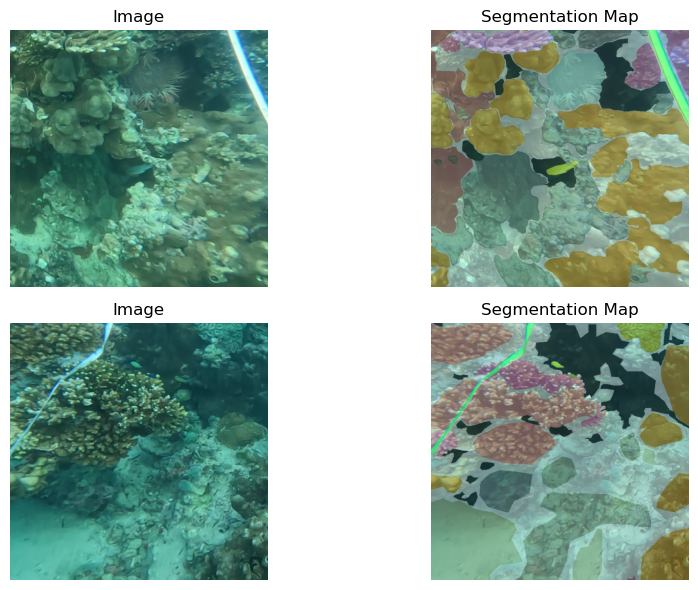

In [13]:
show_samples(train_dataset, n=2)

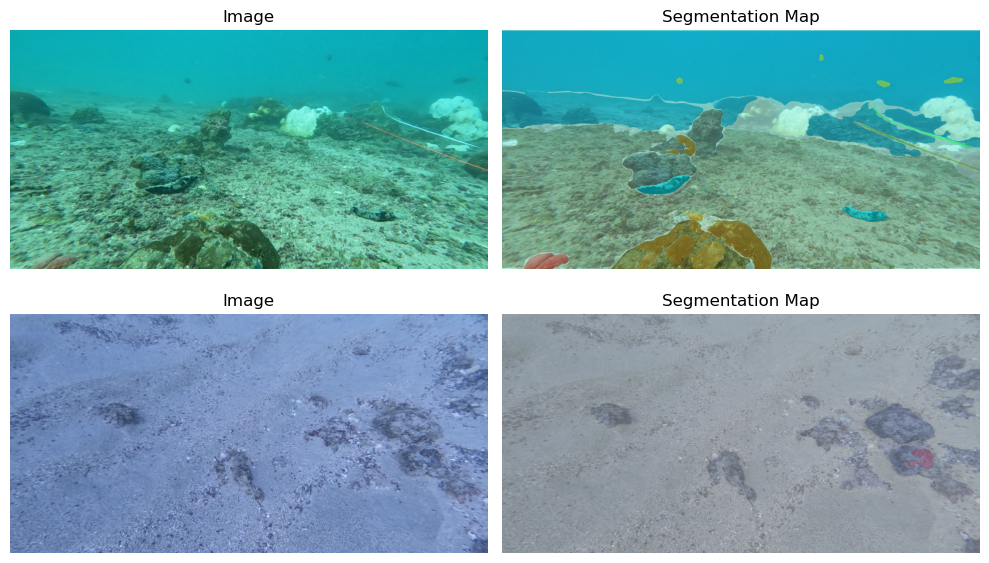

In [14]:
show_samples(val_dataset, n=2)

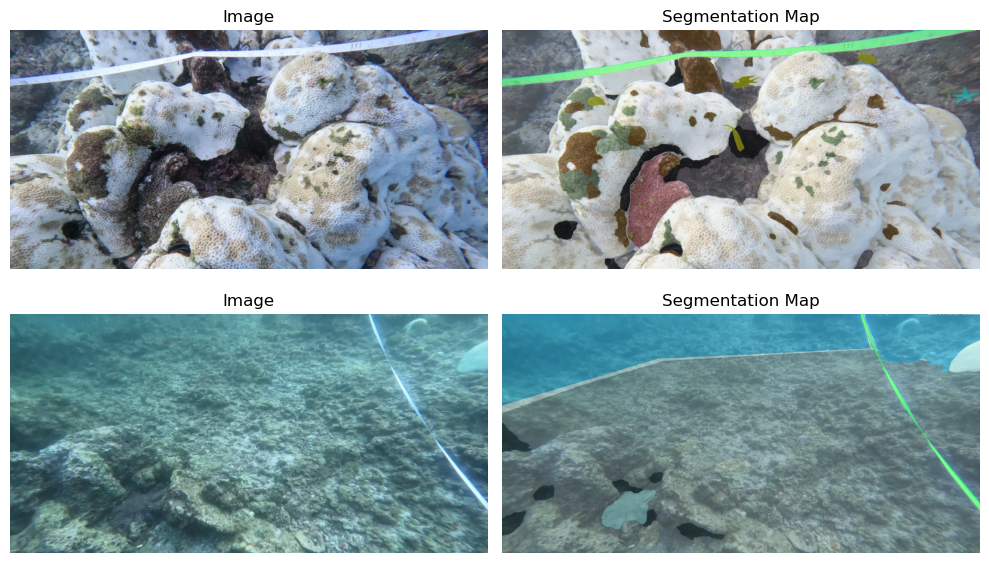

In [15]:
show_samples(test_dataset, n=2)

# Benchmarking

## Model

In [16]:
benchmark_run = Benchmark_Run(run_name = cfg.run_name, model_name = cfg.model.name, 
                                    N_classes = train_dataset.N_classes, device= device, 
                                    model_kwargs = cfg.model.kwargs,
                                    model_checkpoint = cfg.model.checkpoint,
                                    lora_kwargs = cfg.lora,
                                    training_hyperparameters = cfg.training)

## Logger

In [17]:
logger = Logger(
    project = cfg.logger.wandb_project,
    benchmark_run = benchmark_run,
    log_epochs = cfg.logger.log_epochs,
    config = cfg_logger,
    checkpoint_dir = "./tmp"
)
# logger = None

wandb: Currently logged in as: viktor-domazetoski to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## Run

In [18]:
benchmark_run.print_trainable_parameters()

trainable params: 26687608 || all params: 26687608 || trainable%: 100.00


In [ ]:
benchmark_metrics = launch_benchmark(train_loader, val_loader, test_loader, benchmark_run, logger = logger)
save_benchmark_run(benchmark_run, benchmark_metrics)

EPOCH 1:


759it [02:32,  4.97it/s]
83it [00:17,  4.78it/s]

LOSS train 2.259148171453765 valid 1.5823209888963814


Train metrics
{'accuracy': 0.5103315114974976, 'mean_iou': 0.08858293294906616}
Validation metrics
{'accuracy': 0.5585449934005737, 'mean_iou': 0.07830080389976501}
Test metrics
{'accuracy': 0.550338864326477, 'mean_iou': 0.08269968628883362}
EPOCH 2:


759it [02:24,  5.24it/s]
83it [00:15,  5.33it/s]

LOSS train 1.8749669538185059 valid 1.5583102588193962
EPOCH 3:



759it [02:25,  5.22it/s]
83it [00:15,  5.33it/s]

LOSS train 1.789844817166586 valid 1.4866852562829673
EPOCH 4:



759it [02:25,  5.23it/s]
83it [00:15,  5.33it/s]

LOSS train 1.7107778748347668 valid 1.5314804150397519
EPOCH 5:



759it [02:25,  5.23it/s]
83it [00:15,  5.34it/s]

LOSS train 1.6680178695673684 valid 1.2381899916982075
EPOCH 6:



759it [02:25,  5.23it/s]
83it [00:15,  5.33it/s]

LOSS train 1.6040642676931438 valid 1.4323748960552445


Train metrics
{'accuracy': 0.5979665517807007, 'mean_iou': 0.15617333352565765}
Validation metrics
{'accuracy': 0.6084083318710327, 'mean_iou': 0.13101139664649963}
Test metrics
{'accuracy': 0.6006182432174683, 'mean_iou': 0.1410987675189972}
EPOCH 7:


20it [00:04,  4.93it/s]


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fe19e425750>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fe17bce2990, execution_count=20 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7fe1bee39590, raw_cell="benchmark_metrics = launch_benchmark(train_loader,.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Beceo_student/home/viktor/coralscapesScripts/nbs/train.ipynb#X33sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe